Importing the required libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import seed
from random import randrange
from sklearn.preprocessing import Binarizer
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#Question 3.1

Loading the dataset

In [2]:
test = pd.read_csv('fashion-mnist_test.csv')
train = pd.read_csv('fashion-mnist_train.csv')

preprocessing and extracting the required data

In [3]:
#shuffling of data to ensure iid 
np.random.seed(0)
train = train.sample(frac=1)
test = test.sample(frac=1)

In [4]:
#extracting the required data
train = train.loc[(train["label"] == 1) | (train["label"] == 2)]
test = test.loc[(test["label"] == 1) | (test["label"] == 2)]

In [5]:
#Dividing the data into target and feature sample
X_train = train.iloc[:,1:785]
Y_train = train.iloc[:,0]
X_test = test.iloc[:,1:785]
Y_test = test.iloc[:,0]

In [6]:
#binarizing the image
binarizer = Binarizer(127)
X_train= binarizer.fit_transform(X_train)
X_test= binarizer.fit_transform(X_test)

In [7]:
#accuracy function
""" 
    Parameters:
    y: actual values
    y_pred: predicted values

    Returns:
    accuracy
    
    """  
def Accuracy(y, y_pred):
	correct = 0
	for i in range(len(y)):
		if y[i] == y_pred[i]:
			correct += 1
	return correct / float(len(y)) * 100.0

In [8]:
#implementing the naive bayes from scratch
""" 
    Parameters:
     x: features
     y: target

    Returns:
    accuracy
    
    """
def fitting(X,y):
  global mean , var , priors , classes
  samples, features = X.shape
  classes = np.unique(y)
  n_classes = len(classes)

  # calculating the mean, variance and prior P(H) for each class
  mean = np.zeros([n_classes, features], dtype=np.float64)
  var = np.zeros([n_classes, features], dtype=np.float64)
  priors =  np.zeros(n_classes, dtype=np.float64)

  # iterating in all classes
  for i, c in enumerate(classes):

    X_for_class_c = X[y==c].astype(int)
    mean[i, :] = X_for_class_c.mean(axis=0)
    var[i, :] = X_for_class_c.var(axis=0)
    priors[i] = X_for_class_c.shape[0] / float(samples) 


In [9]:
# for predicting test set
def prediction(X):
  y_pred = []
  for x in X :
    # calculating posterior probability for each class
    posteriors = []
    for i, c in enumerate(classes):
      prior = np.log(priors[i])
      # calculating likelihood for each class
      m = mean[i]
      v = var[i]
      num = np.exp(- (x-m)**2 / (2 * v))
      den = np.sqrt(2 * np.pi * v)
      posterior = np.sum(np.log(num / den))
      posterior = prior + posterior
      posteriors.append(posterior)
      
      #  gives class with highest posterior probability
    maX = classes[np.argmax(posteriors)]
    y_pred.append(maX)
    
  return y_pred

In [10]:
fitting(X_train, Y_train)
y_p = prediction(X_test)
y = Y_test.tolist()
ac = Accuracy(y , y_p)
print(f"Naive Bayes accuracy: {ac}")

Naive Bayes accuracy: 50.0


#Question 3.2

In [11]:
#spliting a dataset into k folds
""" 
    Parameters:
     dataset: features
     n_folds : k

    Returns:
    data_spilt : spilted data into k folds
    """
def cross_validation_split(dataset, n_folds):
  dataset_split = list()
  dataset_copy = list(dataset)
  #fold size = total rows/total folds
  fold_size = int(len(dataset) / n_folds)
  for i in range(n_folds):
    fold = list()
    while len(fold) < fold_size:
      #randomly spilting the entire dataset into k folds
      index = randrange(len(dataset_copy))
      fold.append(dataset_copy.pop(index))
    dataset_split.append(fold)
  return dataset_split

In [12]:
#helper function for k fold
""" 
    Parameters:
     train: train data
     test : test data

    Returns:
    pred_Y : predicted values
    """
def Naive_Bayes_helper(train, test):

  train =  pd.DataFrame(train)
  test = pd.DataFrame(test)
  X_train = train.iloc[:,1:785]
  Y_train = train.iloc[:,0]
  X_test = test.iloc[:,1:785]
  Y_test = test.iloc[:,0]
  binarizer = Binarizer(127)
  X_train= binarizer.fit_transform(X_train)
  X_test= binarizer.fit_transform(X_test)
  fitting(X_train, Y_train)
  pred_Y = prediction(X_test)
  
  return pred_Y


In [13]:
#K fold cross validation
""" 
    Parameters:
     dataset: features
     n_folds : k

    Returns:
    scores : scores on each folds 
    predicted : predicted vales
    
    """
def kFold_cross_validation(dataset, n_folds):
  folds = cross_validation_split(dataset, n_folds)
  scores = list()
  for i in range(n_folds):
    fold= folds[i]
    train_data =list(folds)
    train_data.pop(i)
    train_data = sum(train_data, [])
    test_data= list()
    for row in fold:
      row_copy = list(row)
      test_data.append(row_copy)
      row_copy[0] = None
    predicted = Naive_Bayes_helper(train_data, test_data)
    actual = [row[0] for row in fold]
     # calculating accuracy on each fold
    accuracy = Accuracy(actual, predicted)
    scores.append(accuracy)
  return scores , predicted , actual

data_set= pd.concat([train, test])
n_folds= 4
scores , predict ,actual  = kFold_cross_validation(np.array(data_set), n_folds)
print("Scores  : {} ".format(scores))
#average of all the recorded accuracy
accuracy =  np.average(scores)
print("Mean Accuracy  : {} ".format(accuracy))

Scores  : [50.31428571428571, 50.68571428571429, 49.714285714285715, 49.28571428571429] 
Mean Accuracy  : 50.0 


#Question 3.3

Making the Confusion Matrix and calculating accuracy, precision recall

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

In [15]:
# for simple naive bayes
fitting(X_train, Y_train)
y_p = prediction(X_test)
y = Y_test.tolist()
confusion_matrix(y, y_p)

con_mat = confusion_matrix(y, y_p)
acc = accuracy_score(y, y_p)
prec = precision_score(y, y_p)
recall = recall_score(y, y_p)

print(f"Confusion Matrix: {con_mat}")
print(f"Accuracy: {acc}")
print(f"Precision : {prec}")
print(f"Recall : {recall}")
print(classification_report(y, y_p))

Confusion Matrix: [[1000    0]
 [1000    0]]
Accuracy: 0.5
Precision : 0.5
Recall : 1.0
              precision    recall  f1-score   support

           1       0.50      1.00      0.67      1000
           2       0.00      0.00      0.00      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



In [16]:
# for k fold naive bayes
con_mat = confusion_matrix(actual, predict)
acc = accuracy_score(actual, predict)
prec = precision_score(actual, predict)
recall = recall_score(actual, predict)

print(f"Confusion Matrix: {con_mat}")
print(f"Accuracy: {acc}")
print(f"Precision : {prec}")
print(f"Recall : {recall}")
print(classification_report(actual, predict))


Confusion Matrix: [[1725    0]
 [1775    0]]
Accuracy: 0.4928571428571429
Precision : 0.4928571428571429
Recall : 1.0
              precision    recall  f1-score   support

           1       0.49      1.00      0.66      1725
           2       0.00      0.00      0.00      1775

    accuracy                           0.49      3500
   macro avg       0.25      0.50      0.33      3500
weighted avg       0.24      0.49      0.33      3500



Plotting the ROC Curve

Text(0.5, 1.0, 'ROC curve for K Fold')

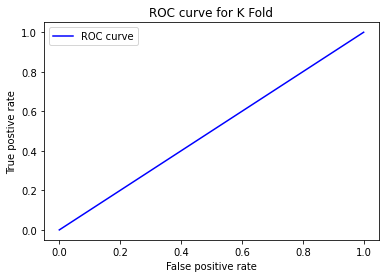

In [17]:
#ROC curve for K fold naive bayes
fpr, tpr, thresholds = roc_curve(actual, predict , pos_label=1)
plt.xlabel('False positive rate')
plt.ylabel('True postive rate')
plt.plot(fpr, tpr,markersize=2, color='blue', label='ROC curve')
plt.legend()
plt.title("ROC curve for K Fold")

Text(0.5, 1.0, 'ROC curve for naive bayes')

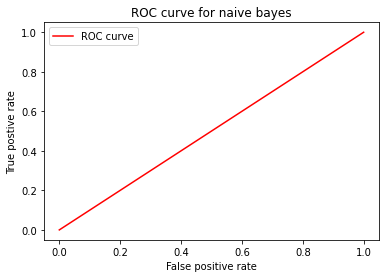

In [18]:
#ROC curve for simple naive bayes
fpr, tpr, thresholds = roc_curve(y, y_p , pos_label=1)
plt.xlabel('False positive rate')
plt.ylabel('True postive rate')
plt.plot(fpr, tpr,markersize=2, color='red', label='ROC curve')
plt.legend()
plt.title("ROC curve for naive bayes")